In [1]:
# Imports
from os import chdir
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import pandas as pd
from IPython.display import clear_output
import seaborn as sns
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from matplotlib.ticker import PercentFormatter, FixedLocator
sns.set_style('whitegrid')

In [2]:
# Move up two directories, to project base directory
chdir("../..")

In [3]:
ddf_reviews = dd.read_parquet("data/reviews.parquet")
df_reviews = ddf_reviews.compute()

In [4]:
# Imports reviews
df_reviews = df_reviews[['author_steamid','steam_appid','voted_up']]

# Imports games
df_games = pd.read_parquet("data/store_info.parquet")

# Adds game name, price, free flag, and recommendation count to reviews dataframe.
# Index is reset and then set because pandas.DataFrame.merge removes the index otherwise
df_reviews = df_reviews.reset_index(drop=False).merge(df_games[['name','price','is_free','recommendations']], left_on='steam_appid', right_on='steam_appid').set_index('recommendationid').rename(columns={"name":"app_name"})

# Previews DataFrame
df_reviews.head()

,author_steamid,steam_appid,voted_up,app_name,price,is_free,recommendations
recommendationid,,,,,,,
92426316,76561197991126058,1000000,True,ASCENXION,9.99,False,0
92738312,76561198043369921,1000000,True,ASCENXION,9.99,False,0
95149549,76561198308633526,1000000,False,ASCENXION,9.99,False,0
116584366,76561197990036156,1000000,False,ASCENXION,9.99,False,0
129441214,76561198281676677,1000000,False,ASCENXION,9.99,False,0


In [5]:
# Log-transforms numeric features. Replaces zeros with appropriately small values so that they don't become NaNs.
df_reviews["recommendations"] = np.log10(df_reviews["recommendations"].replace(0,10))
df_reviews["price"] = np.log10(df_reviews["price"].replace(0,0.01)*100)
df_reviews.head()

,author_steamid,steam_appid,voted_up,app_name,price,is_free,recommendations
recommendationid,,,,,,,
92426316,76561197991126058,1000000,True,ASCENXION,2.999565,False,1.0
92738312,76561198043369921,1000000,True,ASCENXION,2.999565,False,1.0
95149549,76561198308633526,1000000,False,ASCENXION,2.999565,False,1.0
116584366,76561197990036156,1000000,False,ASCENXION,2.999565,False,1.0
129441214,76561198281676677,1000000,False,ASCENXION,2.999565,False,1.0


In [6]:
# Loads graph-derived labels

# Imports labels from positive review graph
ddf_labels_postive = dd.read_parquet("reviews_labeled_positive.parquet")
# Renames label columns
ddf_labels_postive = ddf_labels_postive.rename(columns={'author_label':'author_label_positive','app_label':'app_label_positive'})
# Calls compute method to execute delayed instructions. Using dask here is probably totally unnecessary.
df_labels_positive = ddf_labels_postive.compute()

# Same as above for labels from negative review graph
ddf_labels_negative = dd.read_parquet("reviews_labeled_negative.parquet")
ddf_labels_negative = ddf_labels_negative.rename(columns={'author_label':'author_label_negative','app_label':'app_label_negative'})
df_labels_negative = ddf_labels_negative.compute()

In [7]:
# Joins graph-derived labels with reviews
df_reviews = df_reviews.join(df_labels_positive[['author_label_positive','app_label_positive']])
df_reviews = df_reviews.join(df_labels_negative[['author_label_negative','app_label_negative']])
df_reviews.head()

,author_steamid,steam_appid,voted_up,app_name,price,is_free,recommendations,author_label_positive,app_label_positive,author_label_negative,app_label_negative
recommendationid,,,,,,,,,,,
92426316,76561197991126058,1000000,True,ASCENXION,2.999565,False,1.0,0.0,0.0,NaN,NaN
92738312,76561198043369921,1000000,True,ASCENXION,2.999565,False,1.0,0.0,0.0,NaN,NaN
95149549,76561198308633526,1000000,False,ASCENXION,2.999565,False,1.0,1.0,0.0,0.0,0.0
116584366,76561197990036156,1000000,False,ASCENXION,2.999565,False,1.0,1.0,0.0,1.0,0.0
129441214,76561198281676677,1000000,False,ASCENXION,2.999565,False,1.0,0.0,0.0,0.0,0.0


In [8]:
# Prints % null values
df_reviews.isna().sum()/len(df_reviews) * 100

author_steamid            0.000000
steam_appid               0.000000
voted_up                  0.000000
app_name                  0.000000
price                     0.000000
is_free                   0.000000
recommendations           0.000000
author_label_positive     2.740021
app_label_positive        2.740021
author_label_negative    72.770798
app_label_negative       72.770798
dtype: float64

In [9]:
# Clusters authors/apps not in clusters.
for col in ["author_label_positive", "app_label_positive", "author_label_negative", "app_label_negative"]:
    df_reviews[col] = df_reviews[col].fillna(df_reviews[col].max()+1).astype(int)

In [10]:
# Packs review author/app labels into tuples
for sentiment in ["positive", "negative"]:
    df_reviews["labels_tuple_" + sentiment] = [
        *zip(
            df_reviews["author_label_" + sentiment].values,
            df_reviews["app_label_" + sentiment].values,
        )
    ]
    

df_reviews["labels_tuple_posneg"] = [
    *zip(
        df_reviews["author_label_negative"].values,
        df_reviews["app_label_positive"].values,
    )
]
df_reviews = df_reviews.drop(["author_steamid", "app_name", "author_label_positive", "app_label_positive", "author_label_negative", "app_label_negative"], axis=1)

df_reviews.head()

,steam_appid,voted_up,price,is_free,recommendations,labels_tuple_positive,labels_tuple_negative,labels_tuple_posneg
recommendationid,,,,,,,,
92426316,1000000,True,2.999565,False,1.0,"(0, 0)","(1258, 1066)","(1258, 0)"
92738312,1000000,True,2.999565,False,1.0,"(0, 0)","(1258, 1066)","(1258, 0)"
95149549,1000000,False,2.999565,False,1.0,"(1, 0)","(0, 0)","(0, 0)"
116584366,1000000,False,2.999565,False,1.0,"(1, 0)","(1, 0)","(1, 0)"
129441214,1000000,False,2.999565,False,1.0,"(0, 0)","(0, 0)","(0, 0)"


In [11]:
X = df_reviews.drop("voted_up", axis=1)
y = df_reviews["voted_up"]

In [12]:
# Instantiates pipeline
pipe = Pipeline(
    [
        (
            "transformers",
            ColumnTransformer(  # Column transformer to handle columns differently
                [
                    (
                        "dropper",  # Dropper to remove unnecessary columns
                        "drop",
                        [
                            "steam_appid",
                            "game_positive_reviews",
                            "game_negative_reviews",
                            "labels_tuple_positive",
                            "labels_tuple_negative",
                            "labels_tuple_posneg",
                            "label_prediction_posneg", # Excluding for now...
                        ],
                    ),
                    (
                        "scaler",   # Robust scaler for values not already in range 0-1
                        RobustScaler(),
                        ["recommendations", "price", "review_positivity"],
                    ),
                ],
                remainder="passthrough",    # Features passed through should already be in range 0-1
                force_int_remainder_cols=False,
            ),
        ),
        (
            "classifier",
            LogisticRegressionCV(
                n_jobs=-1, solver="newton-cholesky", scoring="neg_log_loss"
            ),
        ),
    ]
)

# Instantiates simple logreg classifier
logreg_labels_only = LogisticRegressionCV(
    n_jobs=-1, solver="newton-cholesky", scoring="neg_log_loss"
)

In [13]:
# Instantiates empty dataframes to hold model results
df_full_model = pd.DataFrame()
df_label_model = pd.DataFrame()
df_pos_label_model = pd.DataFrame()
df_neg_label_model = pd.DataFrame()
df_posneg_label_model = pd.DataFrame()
df_majority_model = pd.DataFrame()

# For loop to give a better sense of model performance
for random_state in range(100):
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    # Creates training dataframe
    df_train = X_train.copy()
    df_train["voted_up"] = y_train

    # Loops through sentiment tuples
    for sentiment in ["positive", "negative", "posneg"]:
        # Calculates positive sentiment odds per label tuple IN TRRAINING SET
        dict_predictions = (
            df_train.groupby("labels_tuple_" + sentiment)["voted_up"].mean().to_dict()
        )

        # Adds per-label positive sentiment odds to training set (not used in fit)
        df_train["label_prediction_" + sentiment] = df_train["labels_tuple_" + sentiment].map(
            dict_predictions
        )

        # Adds per-label positive sentiment odds to training set (used in fit)
        X_train["label_prediction_" + sentiment] = X_train[
            "labels_tuple_" + sentiment
        ].map(dict_predictions)

        # Adds per-label positive sentiment odds calculated based on training set to test set
        X_test["label_prediction_" + sentiment] = (
            X_test["labels_tuple_" + sentiment]
            .map(dict_predictions)
            .fillna(df_train.groupby("voted_up")["label_prediction_" + sentiment].mean().mean())    # Label combinations not in training set are estimated to have positive sentiment odds equal to the average of the averages of positive and negative sentiment odds
        )


    # Gets game positive review counts
    dict_train_positive_reviews = (
        df_train[df_train["voted_up"] == True]["steam_appid"].value_counts().to_dict()
    )

    # Adds game positive review counts to training set (for fit)
    X_train["game_positive_reviews"] = (
        X_train["steam_appid"].map(dict_train_positive_reviews).fillna(0)
    )
    
    # Adds game positive reviews (FROM TRAINING SET) to test set
    X_test["game_positive_reviews"] = (
        X_test["steam_appid"].map(dict_train_positive_reviews).fillna(0)
    )
    
    # Same as above three assignments, but for negative reviews
    dict_train_negative_reviews = (
        df_train[df_train["voted_up"] == False]["steam_appid"].value_counts().to_dict()
    )

    X_train["game_negative_reviews"] = (
        X_train["steam_appid"].map(dict_train_negative_reviews).fillna(0)
    )
    X_test["game_negative_reviews"] = (
        X_test["steam_appid"].map(dict_train_negative_reviews).fillna(0)
    )

    # For train and test set, calculates logarithm of (positive reviews count) / (negative review count). Replaces zeros with ones so that log operation is happy.
    X_train["review_positivity"] = np.log10(
        (
            X_train["game_positive_reviews"].replace(0, 1)
            / X_train["game_negative_reviews"].replace(0, 1)
        )
    )
    X_test["review_positivity"] = np.log10(
        (
            X_test["game_positive_reviews"].replace(0, 1)
            / X_test["game_negative_reviews"].replace(0, 1)
        )
    )

    # Fits full model
    pipe.fit(X_train, y_train)
    # Gets predictions
    y_pred_full = pipe.predict(X_test)
    # Gets confusion matrix
    full_model_confusion = confusion_matrix(y_test, y_pred_full)
    # Adds confusion matrix results to dataframe
    df_full_model = pd.concat(
        [df_full_model, pd.DataFrame(full_model_confusion.flatten()).transpose()]
    )

    # Blocks below fit labels trained only on label combinations
    logreg_labels_only.fit(X_train[["label_prediction_positive","label_prediction_negative"]], y_train)
    y_pred_label = logreg_labels_only.predict(X_test[["label_prediction_positive","label_prediction_negative"]])
    label_model_confusion = confusion_matrix(y_test, y_pred_label)
    df_label_model = pd.concat(
        [df_label_model, pd.DataFrame(label_model_confusion.flatten()).transpose()]
    )

    logreg_labels_only.fit(X_train[["label_prediction_positive"]], y_train)
    y_pred_label_pos = logreg_labels_only.predict(X_test[["label_prediction_positive"]])
    pos_label_model_confusion = confusion_matrix(y_test, y_pred_label_pos)
    df_pos_label_model = pd.concat(
        [df_pos_label_model, pd.DataFrame(pos_label_model_confusion.flatten()).transpose()]
    )
    
    logreg_labels_only.fit(X_train[["label_prediction_negative"]], y_train)
    y_pred_label_neg = logreg_labels_only.predict(X_test[["label_prediction_negative"]])
    neg_label_model_confusion = confusion_matrix(y_test, y_pred_label_neg)
    df_neg_label_model = pd.concat(
        [df_neg_label_model, pd.DataFrame(neg_label_model_confusion.flatten()).transpose()]
    )
    
    logreg_labels_only.fit(X_train[["label_prediction_posneg"]], y_train)
    y_pred_label_posneg = logreg_labels_only.predict(X_test[["label_prediction_posneg"]])
    posneg_label_model_confusion = confusion_matrix(y_test, y_pred_label_posneg)
    df_posneg_label_model = pd.concat(
        [df_posneg_label_model, pd.DataFrame(posneg_label_model_confusion.flatten()).transpose()]
    )

    # Scores model that assumes all reviews are recommendations
    majority_model_confusion = confusion_matrix(y_test, np.ones(len(y_test)))
    df_majority_model = pd.concat(
        [
            df_majority_model,
            pd.DataFrame(majority_model_confusion.flatten()).transpose(),
        ]
    )
    
    clear_output()
    print(f"Batch {random_state+1}/100 processed.")

Batch 100/100 processed.


In [14]:
# Adds identifier column to results dataframes
df_full_model["Features"] = "Labels + Numeric Features"
df_label_model["Features"] = "Labels"
df_pos_label_model["Features"] = "Labels (Positive)"
df_neg_label_model["Features"] = "Labels (Negative)"
df_posneg_label_model["Features"] = "Labels (Positive/Negative)"
df_majority_model["Features"] = "None"

# Gives results columns useful names.
# Done outside of for-loop as the rename method would create a new dataframe instead of updating
df_full_model = df_full_model.rename(columns={0: "TN", 1: "FP", 2: "FN", 3: "TP"})
df_label_model = df_label_model.rename(columns={0: "TN", 1: "FP", 2: "FN", 3: "TP"})
df_pos_label_model = df_pos_label_model.rename(
    columns={0: "TN", 1: "FP", 2: "FN", 3: "TP"}
)
df_neg_label_model = df_neg_label_model.rename(
    columns={0: "TN", 1: "FP", 2: "FN", 3: "TP"}
)
df_posneg_label_model = df_neg_label_model.rename(
    columns={0: "TN", 1: "FP", 2: "FN", 3: "TP"}
)
df_majority_model = df_majority_model.rename(
    columns={0: "TN", 1: "FP", 2: "FN", 3: "TP"}
)

# Loops through each dataframe, adding columns for accuracy, precision, recall, and F! score.
# Replaces anticipatednulls (only resulting from assuming all reviews are recommendations) with zeros.
for df_results in [df_full_model, df_label_model, df_majority_model, df_pos_label_model, df_neg_label_model, df_posneg_label_model]:
    df_results["Accuracy"] = (df_results["TP"] + df_results["TN"]) / (
        df_results["TP"] + df_results["TN"] + df_results["FP"] + df_results["FN"]
    )
    df_results["Recall: Positive"] = df_results["TP"] / (
        df_results["TP"] + df_results["FN"]
    )
    df_results["Recall: Negative"] = (
        df_results["TN"] / (df_results["TN"] + df_results["FP"])
    ).fillna(0)
    df_results["Precision: Positive"] = df_results["TP"] / (
        df_results["TP"] + df_results["FP"]
    )
    df_results["Precision: Negative"] = (
        df_results["TN"] / (df_results["TN"] + df_results["FN"])
    ).fillna(0)
    df_results["F1: Positive"] = 2 / (
        df_results["Recall: Positive"] ** -1 + df_results["Precision: Positive"] ** -1
    )
    df_results["F1: Negative"] = (
        2
        / (
            df_results["Recall: Negative"] ** -1
            + df_results["Precision: Negative"] ** -1
        )
    ).fillna(0)

In [21]:
# Concatenates and saves results dataframes

df_results = pd.concat(
    [
        df_full_model.reset_index(drop=True).reset_index(),
        df_label_model.reset_index(drop=True).reset_index(),
        df_pos_label_model.reset_index(drop=True).reset_index(),
        df_neg_label_model.reset_index(drop=True).reset_index(),
        df_posneg_label_model.reset_index(drop=True).reset_index(),
        df_majority_model.reset_index(drop=True).reset_index(),
    ]
)

df_results.to_parquet("models/results/logistic_results.parquet")

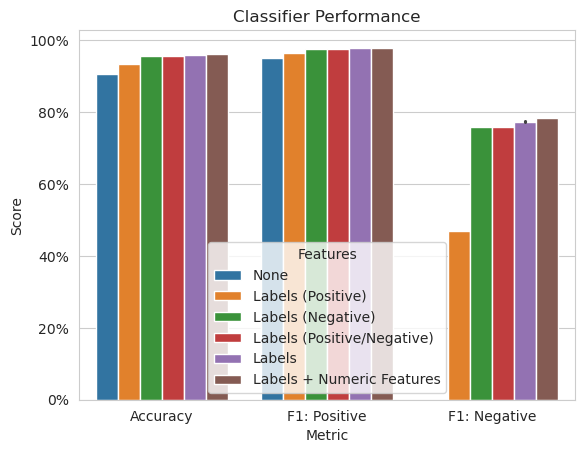

In [24]:
df_model_comparison = pd.melt(
    df_results,
    id_vars="Features",
    value_vars=["Accuracy", "F1: Positive", "F1: Negative"],
    var_name="Metric",
    value_name="Score",
)

sns.barplot(
    df_model_comparison,
    x="Metric",
    y="Score",
    hue="Features",
    errorbar="sd",
    hue_order=[
        "None",
        "Labels (Positive)",
        "Labels (Negative)",
        "Labels (Positive/Negative)",
        "Labels",
        "Labels + Numeric Features",
    ],
)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.grid(visible=True, which='minor', axis='y', linestyle='dotted', linewidth=1)
plt.title('Classifier Performance')
plt.show()

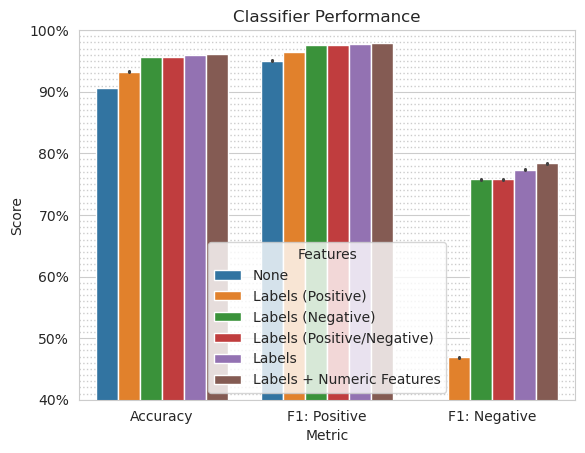

In [27]:
df_model_comparison = pd.melt(
    df_results,
    id_vars="Features",
    value_vars=["Accuracy", "F1: Positive", "F1: Negative"],
    var_name="Metric",
    value_name="Score",
)

sns.barplot(
    df_model_comparison,
    x="Metric",
    y="Score",
    hue="Features",
    errorbar="sd",
    hue_order=[
        "None",
        "Labels (Positive)",
        "Labels (Negative)",
        "Labels (Positive/Negative)",
        "Labels",
        "Labels + Numeric Features",
    ],
)
plt.ylim((0.4, 1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_minor_locator(FixedLocator(np.arange(0.4,1.01,0.01)))
plt.grid(visible=True, which='minor', axis='y', linestyle='dotted', linewidth=1)
plt.title('Classifier Performance')
plt.show()